In [2]:
import sys
import os 
import numpy as np
import seaborn.apionly as sns
from matplotlib import ticker
import matplotlib.pyplot as plt
plt.style.use('papers')
%matplotlib inline
root_path = '/home/wtb2/Documents'
sys.path.append(os.path.join(root_path,'EBTEL_analysis/src/'))
import ebtel_run as ebr
import ebtel_configure as ebc
import ebtel_plot as ebp

# Hot Plasma Paper 1–Figures, Appendix

Here, we'll build the figure(s) needed for Hot Plasma Paper 1 Appendix.

## Figure 1
The first figure will show the relative importance of $\psi_{TR}$ in the EBTEL two-fluid equations. Consider the equation,
$$
\frac{L}{\gamma - 1}\frac{dp_e}{dt} = \psi_{TR} - (\mathcal{R}_C + \mathcal{R}_{TR}) + \frac{L}{\gamma - 1}k_Bn\nu_{ei}(T_i - T_e) + LQ_e.
$$
We want to plot each term as a function of time to show their relative contributions to the evolution of the electron energy.

We will use the following parameters for our sample run:

+ $L=40$ Mm
+ $\tau=200$ s
+ $H_0=0.1$ erg cm$^{-3}$ s$^{-1}$
+ Spitzer conduction

Configure dictionary to run EBTEL-2fluid model.

In [8]:
#input dictionary
config_dict = {'usage_option':'dem','rad_option':'rk','dem_option':'new','heat_flux_option':'classical',
              'solver':'euler','ic_mode':'st_eq','print_plasma_params':'True','heat_species':'electron'}
config_dict['total_time'] = 5000
config_dict['tau'] = 1.0
config_dict['rka_error'] = 1.0e-6
config_dict['index_dem'] = 451
config_dict['sat_limit'] = 1.0/6.0
config_dict['h_back'] = 3.4e-6
config_dict['heating_shape'] = 'triangle'
config_dict['t_start_switch'] = 'uniform'
config_dict['t_end_switch'] = 'uniform'
config_dict['T0'] = 1.0e+6
config_dict['n0'] = 1.0e+8
config_dict['t_start'] = 0.0
config_dict['mean_t_start'] = 1000
config_dict['std_t_start'] = 1000
config_dict['amp_switch'] = 'uniform'
config_dict['amp0'] = 0.001
config_dict['amp1'] = 0.01
config_dict['alpha'] = 1.5
config_dict['loop_length'] = 40.0
config_dict['num_events'] = 1
config_dict['t_pulse_half'] = 100
config_dict['h_nano'] = 0.1
config_dict['sample_rate'] = 1
config_dict['output_file'] = '/home/wtb2/Documents/research_notebook/EBTEL/ebtel_data/psi_TR_testing'

In [9]:
configurer = ebc.Configurer(config_dict,'')

In [10]:
configurer.print_xml_config(config_file=config_dict['output_file']+'.xml')

Now, run the two-fluid EBTEL code with this configuration.

In [11]:
runner = ebr.Runner('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/','')

In [12]:
runner.run_ebtel_single(config_dict['output_file']+'.xml')

Next, load the data and plot.

In [55]:
debug_data = np.loadtxt(config_dict['output_file']+'_debug.txt')
min_transform = np.min(debug_data[:,1:])
max_transform = np.max(debug_data[:,1:])
c_transform = 1 - min_transform
cmax_transform = max_transform + c_transform

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


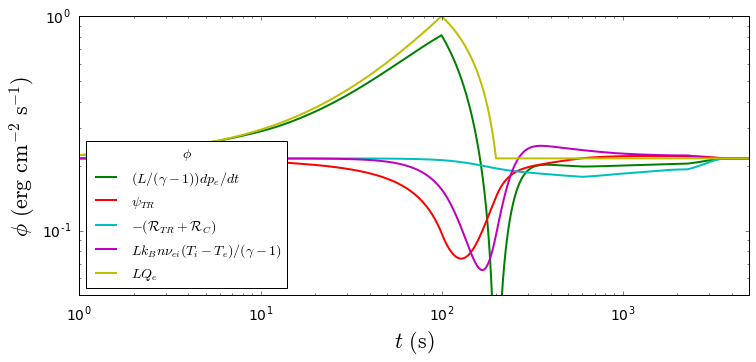

In [93]:
labels = [r'$(L/(\gamma-1))dp_e/dt$',r'$\psi_{TR}$',r'$-(\mathcal{R}_{TR} + \mathcal{R}_C)$',
          r'$Lk_Bn\nu_{ei}(T_i-T_e)/(\gamma-1)$',r'$LQ_e$']
fig = plt.figure(figsize=(12,5))
ax = fig.gca()
for i in range(1,np.shape(debug_data)[1]):
    #if i != 1 and i != 5:
        ax.plot(debug_data[:,0],(debug_data[:,i]+c_transform)/cmax_transform,color=sns.color_palette()[i],label=labels[i-1])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1,config_dict['total_time']])
ax.set_ylim([0.05,1])
ax.set_xlabel(r'$t$ $\mathrm{(s)}$')
ax.set_ylabel(r'$\phi$ $(\mathrm{erg}$ $\mathrm{cm}^{-2}$ $\mathrm{s}^{-1})$')
leg = ax.legend(loc=3,title=r'$\phi$',ncol=1)
plt.setp(leg.get_title(),fontsize=14)
plt.savefig('/home/wtb2/Documents/papers/hot_non-flaring_plasma_1/figures/psi_TR_compare.pdf')